In [159]:
# !pip install "gymnasium[other]"

In [160]:
from collections import deque
from typing import Optional, Tuple, Dict, Any
import gymnasium as gym
import numpy as np

In [161]:
class SnakeEnv(gym.Env):

    metadata = {"render_modes": ["human"], "render_fps": 8}

    def __init__(self, size: int = 10, render_mode: Optional[str] = "human"):
        # The size of the square grid (5x5 by default)
        self.size = size
        self.render_mode = render_mode


        # Actions: 0 right, 1 up, 2 left, 3 down
        self.action_space = gym.spaces.Discrete(4)

        # Observation: grid encoded as integers:
        # 0 empty, 1 snake body, 2 snake head, 3 apple
        self.observation_space = gym.spaces.Dict({
            "grid": gym.spaces.Box(low=0, high=3, shape=(size, size), dtype=np.int8),
            "dir": gym.spaces.Box(low=-1, high=1, shape=(2,), dtype=np.int8),
        })


        self._action_to_dir = {
            0: np.array([1, 0], dtype=np.int32),   # right: x+1
            1: np.array([0, 1], dtype=np.int32),   # up:    y+1
            2: np.array([-1, 0], dtype=np.int32),  # left:  x-1
            3: np.array([0, -1], dtype=np.int32),  # down:  y-1
        }

        self.snake = deque()
        self.direction = np.array([1, 0], dtype=np.int32)
        self.apple = np.array([0, 0], dtype=np.int32)

        # Define what actions are available (4 directions)
        self.action_space = gym.spaces.Discrete(4)

    def _spawn_apple(self):
        occupied = set(self.snake)
        free = [(x, y) for x in range(self.size) for y in range(self.size) if (x, y) not in occupied]
        if not free:
            # No place to spawn: snake filled grid -> win condition
            return None
        x, y = free[self.np_random.integers(0, len(free))]
        return np.array([x, y], dtype=np.int32)
    
    def _get_obs(self):
        grid = np.zeros((self.size, self.size), dtype=np.int8)
        # body
        for (x, y) in list(self.snake)[1:]:
            grid[y, x] = 1
        # head
        hx, hy = self.snake[0]
        grid[hy, hx] = 2
        # apple
        if self.apple is not None:
            ax, ay = int(self.apple[0]), int(self.apple[1])
            grid[ay, ax] = 3
        
        dir_vec = self.direction.astype(np.int8)
        return {"grid": grid, "dir": dir_vec}
    
    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None):
        super().reset(seed=seed)

        # start snake at center, length 3 horizontally
        cx, cy = self.size // 2, self.size // 2
        self.snake = deque([(cx, cy), (cx - 1, cy), (cx - 2, cy)])
        self.direction = np.array([1, 0], dtype=np.int32)

        self.apple = self._spawn_apple()
        obs = self._get_obs()
        info = {"length": len(self.snake)}
        return obs, info
    
    def manhattan(self, a, b):
        return abs(a[0] - b[0]) + abs(a[1] - b[1])

    def step(self, action: int):
        new_dir = self._action_to_dir[int(action)]

        # Optional: prevent immediate reverse
        if np.array_equal(new_dir, -self.direction):
            new_dir = self.direction
        else:
            self.direction = new_dir

        hx, hy = self.snake[0]
        nx, ny = hx + int(self.direction[0]), hy + int(self.direction[1])

        terminated = False
        truncated = False
        reward = 0.0

        # wall collision
        if nx < 0 or nx >= self.size or ny < 0 or ny >= self.size:
            terminated = True
            reward = -5.0
            obs = self._get_obs()
            info = {"length": len(self.snake), "dead": True, "event": "wall"}
            return obs, reward, terminated, truncated, info
        
        old_dist = self.manhattan(self.snake[0], self.apple)

        new_head = (nx, ny)

        # self collision (allow moving into tail ONLY if tail will move away this step)
        will_eat = (self.apple is not None and nx == int(self.apple[0]) and ny == int(self.apple[1]))
        body_set = set(self.snake)
        tail = self.snake[-1]

        if (new_head in body_set) and not (new_head == tail and not will_eat):
            terminated = True
            reward = -1.0
            obs = self._get_obs()
            info = {"length": len(self.snake), "dead": True, "event": "self"}
            return obs, reward, terminated, truncated, info

        # move head
        self.snake.appendleft(new_head)

        new_dist = self.manhattan(new_head, self.apple)

        if will_eat:
            # grow: do NOT pop tail
            reward = +20.0
            self.apple = self._spawn_apple()
            if self.apple is None:
                # filled grid -> win
                terminated = True
                reward = +10.0
                info = {"length": len(self.snake), "dead": False, "event": "filled_grid"}
            else:
                info = {"length": len(self.snake), "dead": False, "event": "eat"}
        else:
            # normal move: remove tail
            self.snake.pop()
            reward = -0.01
            info = {"length": len(self.snake), "dead": False, "event": "move"}

            if new_dist < old_dist:
                reward += 0.1

        obs = self._get_obs()
        return obs, reward, terminated, truncated, info

In [162]:
# Register the environment so we can create it with gym.make()
gym.register(
    id="gymnasium_env/SnakeEnv-v1",
    entry_point=SnakeEnv,
    max_episode_steps=100000,  # Prevent infinite episodes
)

d:\Dev_python\Anaconda\Lib\site-packages\gymnasium\envs\registration.py:636: UserWarning: WARN: Overriding environment gymnasium_env/SnakeEnv-v1 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [163]:
env = gym.make("gymnasium_env/SnakeEnv-v1", size=10)
env.unwrapped.size

10

In [164]:
from gymnasium.utils.env_checker import check_env

# This will catch many common issues
try:
    check_env(env)
    print("Environment passes all checks!")
except Exception as e:
    print(f"Environment has issues: {e}")

Environment has issues: 


d:\Dev_python\Anaconda\Lib\site-packages\gymnasium\utils\env_checker.py:384: UserWarning: WARN: The environment (<TimeLimit<OrderEnforcing<PassiveEnvChecker<SnakeEnv<gymnasium_env/SnakeEnv-v1>>>>>) is different from the unwrapped version (<SnakeEnv<gymnasium_env/SnakeEnv-v1>>). This could effect the environment checker as the environment most likely has a wrapper applied to it. We recommend using the raw environment for `check_env` using `env.unwrapped`.
  logger.warn(


In [165]:
from collections import defaultdict
import gymnasium as gym
import numpy as np


class SnakeAgent:
    def __init__(
        self,
        env: gym.Env,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Q-Learning agent.

        Args:
            env: The training environment
            learning_rate: How quickly to update Q-values (0-1)
            initial_epsilon: Starting exploration rate (usually 1.0)
            epsilon_decay: How much to reduce epsilon each episode
            final_epsilon: Minimum exploration rate (usually 0.1)
            discount_factor: How much to value future rewards (0-1)
        """
        self.env = env

        # Q-table: maps (state, action) to expected reward
        # defaultdict automatically creates entries with zeros for new states
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor  # How much we care about future rewards

        # Exploration parameters
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        # Track learning progress
        self.training_error = []

    def get_action(self, obs: dict) -> int:
        """Choose an action using epsilon-greedy strategy.

        Returns:
            move: 0 (right), 1 (up), 2 (left), or 3 (down)
        """
        # With probability epsilon: explore (random action)
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()

        # With probability (1-epsilon): exploit (best known action)
        else:
            state = self.obs_to_state(obs)
            return int(np.argmax(self.q_values[state]))

        
    def obs_to_state(self, obs: dict) -> tuple[int, ...]:
        grid = obs["grid"]
        dx, dy = int(obs["dir"][0]), int(obs["dir"][1])

        # Head position (value 2)
        hy, hx = np.argwhere(grid == 2)[0]  # (row=y, col=x)

        # Apple position (value 3) - if none, use head
        apple_pos = np.argwhere(grid == 3)
        if apple_pos.size == 0:
            ay, ax = hy, hx
        else:
            ay, ax = apple_pos[0]

        # Body cells (value 1) are obstacles
        body = set(map(tuple, np.argwhere(grid == 1)))  # store (y,x)

        size = grid.shape[0]

        def collision(y, x) -> int:
            if x < 0 or x >= size or y < 0 or y >= size:
                return 1
            if (y, x) in body:
                return 1
            return 0

        # direction flags with your convention (dx,dy) where up is dy==1
        dir_up    = int(dy == 1)
        dir_down  = int(dy == -1)
        dir_right = int(dx == 1)
        dir_left  = int(dx == -1)

        # "front/left/right" relative to current direction (dx,dy) in your coordinate system:
        # front: (hx+dx, hy+dy)
        danger_front = collision(hy + dy, hx + dx)

        # left turn: (-dy, +dx)
        danger_left  = collision(hy + dx, hx - dy)

        # right turn: (+dy, -dx)
        danger_right = collision(hy - dx, hx + dy)

        dx_food = int(np.sign(ax - hx))  # -1,0,1
        dy_food = int(np.sign(ay - hy))

        return (
            danger_front, danger_left, danger_right,
            dir_up, dir_down, dir_left, dir_right,
            dx_food, dy_food
        )


    def update(
        self,
        obs: dict,
        action: int,
        reward: float,
        done: bool,
        next_obs: dict,
    ):
        """Update Q-value based on experience.

        This is the heart of Q-learning: learn from (state, action, reward, next_state)
        """

        state = self.obs_to_state(obs)
        next_state = self.obs_to_state(next_obs)
        # What's the best we could do from the next state?
        # (Zero if episode terminated - no future rewards possible)
        future_q_value = (not done) * np.max(self.q_values[next_state])

        # What should the Q-value be? (Bellman equation)
        target = reward + self.discount_factor * future_q_value

        # How wrong was our current estimate?
        temporal_difference = target - self.q_values[state][action]

        # Update our estimate in the direction of the error
        # Learning rate controls how big steps we take
        self.q_values[state][action] = (
            self.q_values[state][action] + self.lr * temporal_difference
        )

        # Track learning progress (useful for debugging)
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        """Reduce exploration rate after each episode."""
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

In [174]:
# Training hyperparameters
learning_rate = 0.01        # How fast to learn (higher = faster but less stable)
n_episodes = 100000       # Number of game played
start_epsilon = 1.0         # Start with 100% random actions
epsilon_decay = start_epsilon / (0.8 * n_episodes)  # Reduce exploration over time
final_epsilon = 0.02         # Always keep some exploration

# Create environment and agent
env = gym.make("gymnasium_env/SnakeEnv-v1", size=10)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)

agent = SnakeAgent(
    env=env,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    discount_factor=0.95,
)

In [175]:
from tqdm import tqdm

for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    terminated = False
    truncated = False
    dead = False

    while not (terminated or truncated or dead):
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        dead = bool(info.get("dead", False))
        done = terminated or truncated or dead

        agent.update(obs, action, reward, done, next_obs)
        obs = next_obs

    agent.decay_epsilon()


100%|██████████| 100000/100000 [06:23<00:00, 260.87it/s]


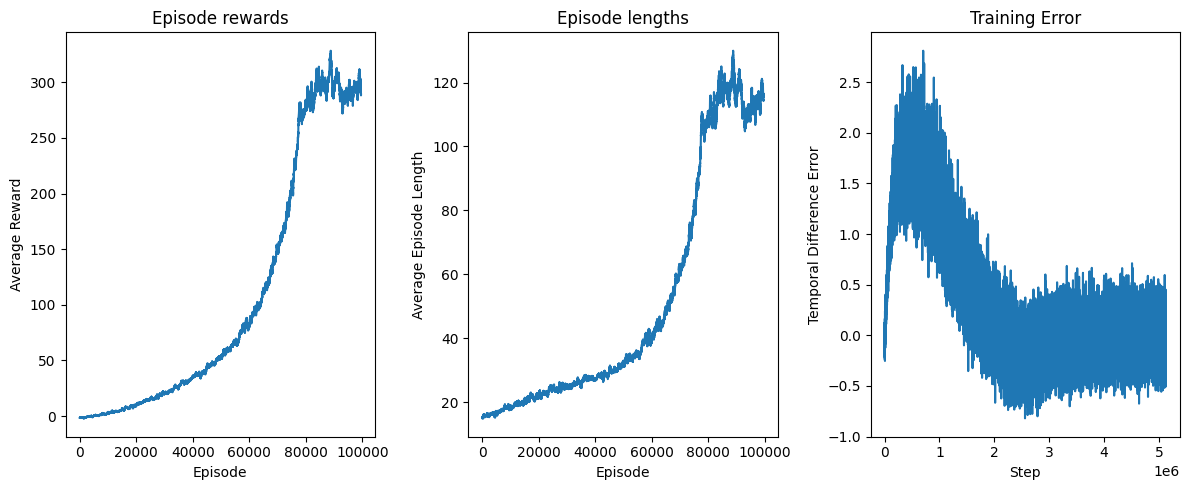

In [176]:
from matplotlib import pyplot as plt

def get_moving_avgs(arr, window, convolution_mode):
    """Compute moving average to smooth noisy data."""
    return np.convolve(
        np.array(arr).flatten(),
        np.ones(window),
        mode=convolution_mode
    ) / window

# Smooth over a 500-episode window
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))

# Episode rewards (win/loss performance)
axs[0].set_title("Episode rewards")
reward_moving_average = get_moving_avgs(
    env.return_queue,
    rolling_length,
    "valid"
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[0].set_ylabel("Average Reward")
axs[0].set_xlabel("Episode")

# Episode lengths (how many actions per hand)
axs[1].set_title("Episode lengths")
length_moving_average = get_moving_avgs(
    env.length_queue,
    rolling_length,
    "valid"
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[1].set_ylabel("Average Episode Length")
axs[1].set_xlabel("Episode")

# Training error (how much we're still learning)
axs[2].set_title("Training Error")
training_error_moving_average = get_moving_avgs(
    agent.training_error,
    rolling_length,
    "same"
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
axs[2].set_ylabel("Temporal Difference Error")
axs[2].set_xlabel("Step")

plt.tight_layout()
plt.show()

In [187]:
import numpy as np

def evaluate_agent(agent, env, num_episodes=200, max_steps=5000):
    """
    Évalue un agent en greedy (epsilon=0) et renvoie des métriques cohérentes pour Snake.

    Hypothèses:
    - env.info contient:
        - "event": "eat" quand une pomme est mangée (comme dans ton env)
        - "dead": True si mort (mur/self)
        - "length": longueur actuelle du snake
    - Reward shaping -> on NE définit PAS la victoire via reward>0.
      On mesure plutôt: pommes mangées, longueur finale, survie, cause de mort, etc.
    """
    old_epsilon = agent.epsilon
    agent.epsilon = 0.0  # greedy

    apples_list = []
    lengths_list = []
    steps_list = []
    died_list = []
    death_event_list = []

    for _ in range(num_episodes):
        obs, info = env.reset()
        terminated = False
        truncated = False
        dead = False

        apples = 0
        steps = 0
        death_event = None

        while not (terminated or truncated or dead) and steps < max_steps:
            action = agent.get_action(obs)
            obs, reward, terminated, truncated, info = env.step(action)
            steps += 1

            dead = bool(info.get("dead", False))
            event = info.get("event", None)

            if event == "eat":
                apples += 1

            if dead and death_event is None:
                death_event = event  # "wall" ou "self"

            if terminated and death_event is None:
                death_event = event  # ex: "filled_grid" si tu le déclenches

        apples_list.append(apples)
        lengths_list.append(int(info.get("length", 0)))
        steps_list.append(steps)
        died_list.append(bool(dead))
        death_event_list.append(death_event)

    agent.epsilon = old_epsilon

    apples_arr = np.array(apples_list, dtype=float)
    lengths_arr = np.array(lengths_list, dtype=float)
    steps_arr = np.array(steps_list, dtype=float)
    died_arr = np.array(died_list, dtype=bool)

    # Statistiques causes de fin
    counts = {}
    for ev in death_event_list:
        counts[ev] = counts.get(ev, 0) + 1

    # Taux utiles
    death_rate = died_arr.mean()
    avg_apples = apples_arr.mean()
    avg_length = lengths_arr.mean()
    avg_steps = steps_arr.mean()

    print(f"Evaluation over {num_episodes} episodes (greedy, max_steps={max_steps}):")
    print(f"- Avg apples eaten: {avg_apples:.3f}  (std {apples_arr.std():.3f})")
    print(f"- Avg final length: {avg_length:.3f}  (std {lengths_arr.std():.3f})")
    print(f"- Avg steps survived: {avg_steps:.1f}  (std {steps_arr.std():.1f})")
    print(f"- Death rate: {death_rate:.1%}")
    print(f"- End events breakdown: {counts}")

    # Optionnel: quelques quantiles pour voir la distribution
    q = [0.1, 0.5, 0.9]
    print(f"- Apples quantiles (10/50/90%): {np.quantile(apples_arr, q)}")
    print(f"- Steps  quantiles (10/50/90%): {np.quantile(steps_arr, q)}")


In [186]:
# Test your agent
evaluate_agent(agent, env)

Evaluation over 200 episodes (greedy, max_steps=5000):
- Avg apples eaten: 17.215  (std 6.269)
- Avg final length: 20.215  (std 6.269)
- Avg steps survived: 135.0  (std 57.7)
- Death rate: 100.0%
- End events breakdown: {'self': 200}
- Apples quantiles (10/50/90%): [10.  16.5 25.1]
- Steps  quantiles (10/50/90%): [ 67.9 123.5 208.3]


{'avg_apples': 17.215,
 'std_apples': 6.268873503269946,
 'avg_length': 20.215,
 'std_length': 6.268873503269946,
 'avg_steps': 134.98,
 'std_steps': 57.74356760713699,
 'death_rate': 1.0,
 'end_events': {'self': 200}}

In [179]:
import numpy as np

def snake_to_frame(env) -> np.ndarray:
    """
    Construit une image (H,W,3) à partir de l'état interne env.snake/env.apple.
    """
    e = env.unwrapped
    size = e.size

    frame = np.zeros((size, size, 3), dtype=np.uint8)

    # Apple
    if getattr(e, "apple", None) is not None:
        ax, ay = int(e.apple[0]), int(e.apple[1])
        frame[ay, ax] = (180, 180, 180)

    # Snake body + head
    snake_list = list(e.snake)
    for i, (x, y) in enumerate(snake_list):
        if i == 0:
            frame[y, x] = (255, 255, 255)  # head
        else:
            frame[y, x] = (120, 120, 120)  # body

    # y vers le haut (optionnel)
    frame = frame[::-1, :, :]
    return frame


In [188]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

def visualize_episode(agent, env, max_steps=1000000, greedy=True):
    old_eps = agent.epsilon
    if greedy:
        agent.epsilon = 0.0

    obs, info = env.reset()
    frames = [snake_to_frame(env)]

    terminated = False
    truncated = False
    dead = False
    steps = 0

    while not (terminated or truncated or dead) and steps < max_steps:
        action = agent.get_action(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        dead = bool(info.get("dead", False))

        frames.append(snake_to_frame(env))
        steps += 1

    agent.epsilon = old_eps

    fig = plt.figure()
    im = plt.imshow(frames[0], interpolation="nearest")
    plt.axis("off")

    def update(i):
        im.set_data(frames[i])
        return (im,)

    ani = animation.FuncAnimation(fig, update, frames=len(frames), interval=120, blit=True)
    plt.close(fig)
    return HTML(ani.to_jshtml())


In [189]:
visualize_episode(agent, env, greedy=True)
